In [ ]:
import os
import math
import pandas as pd
from keras.layers import Dense, Flatten, Dropout,GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height, width = 224, 224
batch_size=64
def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='sparse',
        target_size=(height, width),
        classes={'bed': 0, 'chair': 1,'sofa':2,'swivelchair':3,'table':4,'featurewall':5}
    )
    return generator
TRAINING_DIR = '/content/drive/MyDrive/FYP Dataset/img/train'
TESTING_DIR = '/content/drive/MyDrive/FYP Dataset/img/val'
train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)
total_image = np.concatenate([train_generator.labels,test_generator.labels])
print('\n\n',{'Bed_Images':len(np.where(total_image==0)[0]),
'Chair_Images':len(np.where(total_image==1)[0]),
'Sofa_Images':len(np.where(total_image==2)[0]),
'Swivelchair_Images':len(np.where(total_image==3)[0]),
'Table_Images':len(np.where(total_image==4)[0]),
'FeatureWall_Images':len(np.where(total_image==5)[0])
})

Found 4324 images belonging to 6 classes.
Found 481 images belonging to 6 classes.


 {'Bed_Images': 1000, 'Chair_Images': 1000, 'Sofa_Images': 1000, 'Swivelchair_Images': 1000, 'Table_Images': 447, 'FeatureWall_Images': 358}


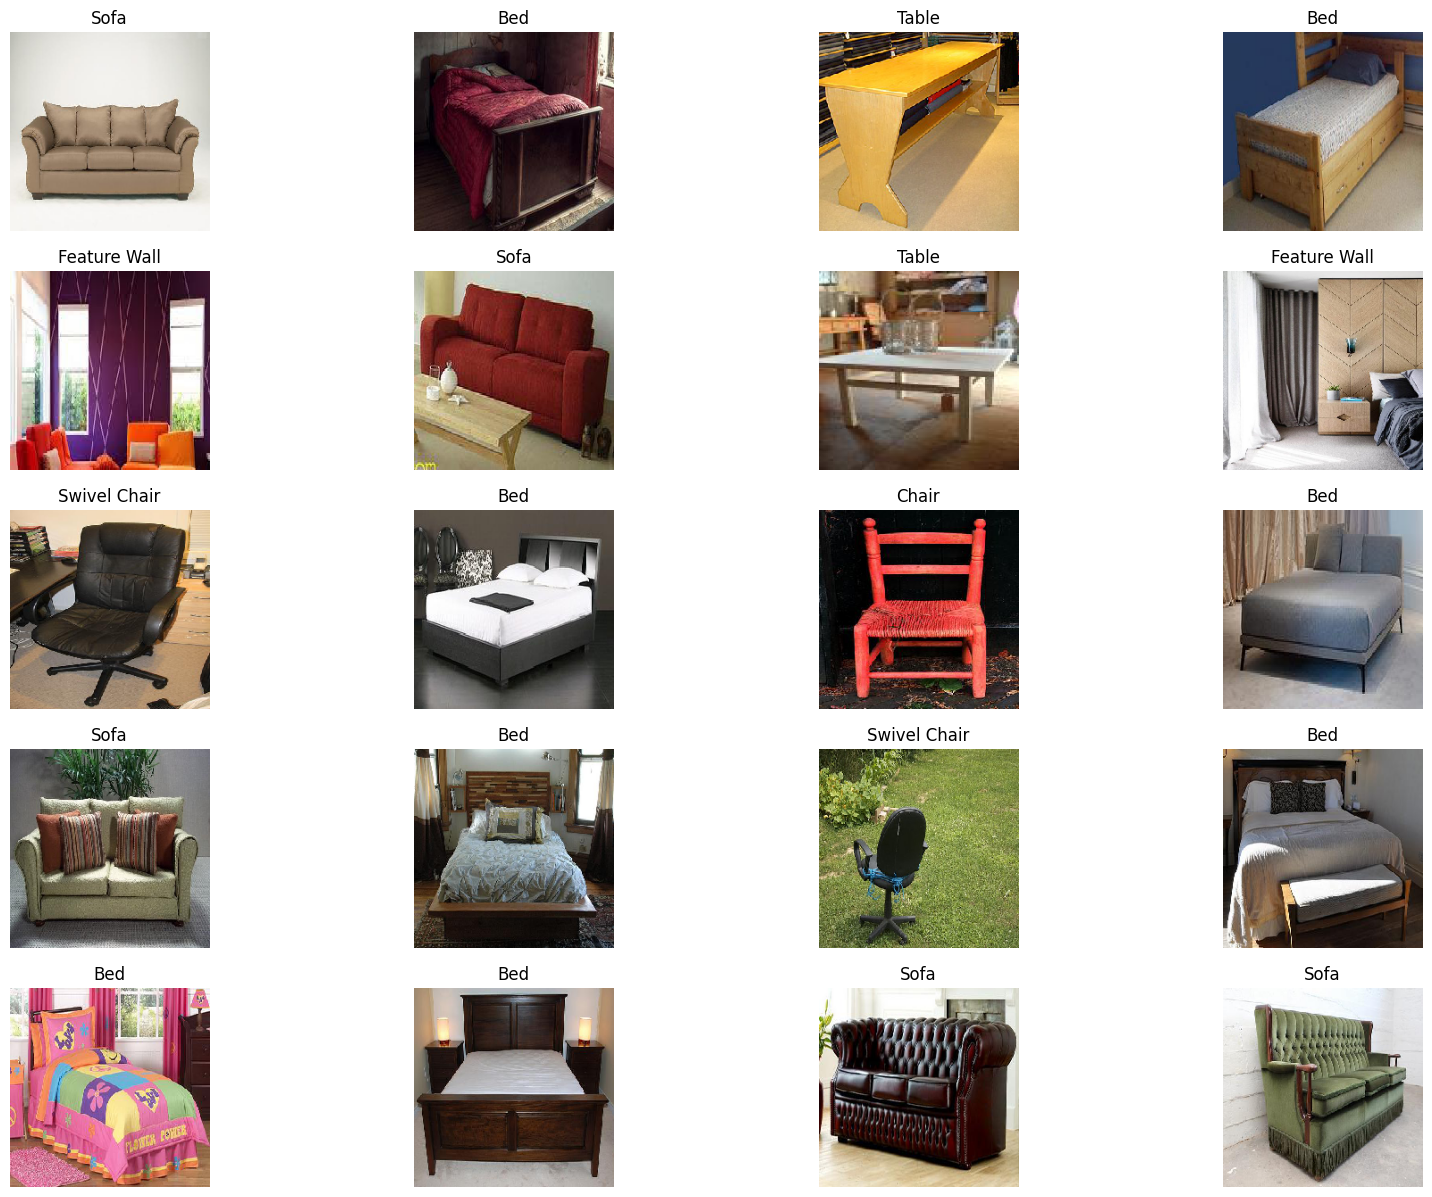

In [ ]:
def image_plot(generator,image_numbers):
  # print(generator[0][0][:image_numbers])
  # print(generator[0][1][:image_numbers])
  img_feature = generator[0][0][:image_numbers]
  img_label = generator[0][1][:image_numbers]
  plt.figure(figsize=(20, 15))
  for i in range(image_numbers):
    ax = plt.subplot(math.ceil(image_numbers/4),4, i+1)
    plt.imshow(img_feature[i])
    if(img_label[i] == 0):
      plt.title("Bed")
    elif(img_label[i] == 1):
      plt.title("Chair")
    elif(img_label[i] == 2):
      plt.title("Sofa")
    elif(img_label[i] == 3):
      plt.title("Swivel Chair")
    elif(img_label[i] == 4):
      plt.title("Table")
    elif(img_label[i] == 5):
      plt.title("Feature Wall")
    plt.axis("off")
image_plot(train_generator,20)



In [ ]:
def generate_data_augmented(DIR):
  datagen = ImageDataGenerator(
    rescale=1./255.,
    zoom_range=0.2,
    shear_range = 0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True
  )
  generator = datagen.flow_from_directory(
    DIR,
    batch_size=batch_size,
    seed=42,
    class_mode='sparse',
    target_size=(height, width),
    classes={'bed': 0, 'chair': 1,'sofa':2,'swivelchair':3,'table':4,'featurewall':5}
  )
  return generator


In [ ]:
aug_train_generator = generate_data_augmented(TRAINING_DIR)

Found 4324 images belonging to 6 classes.


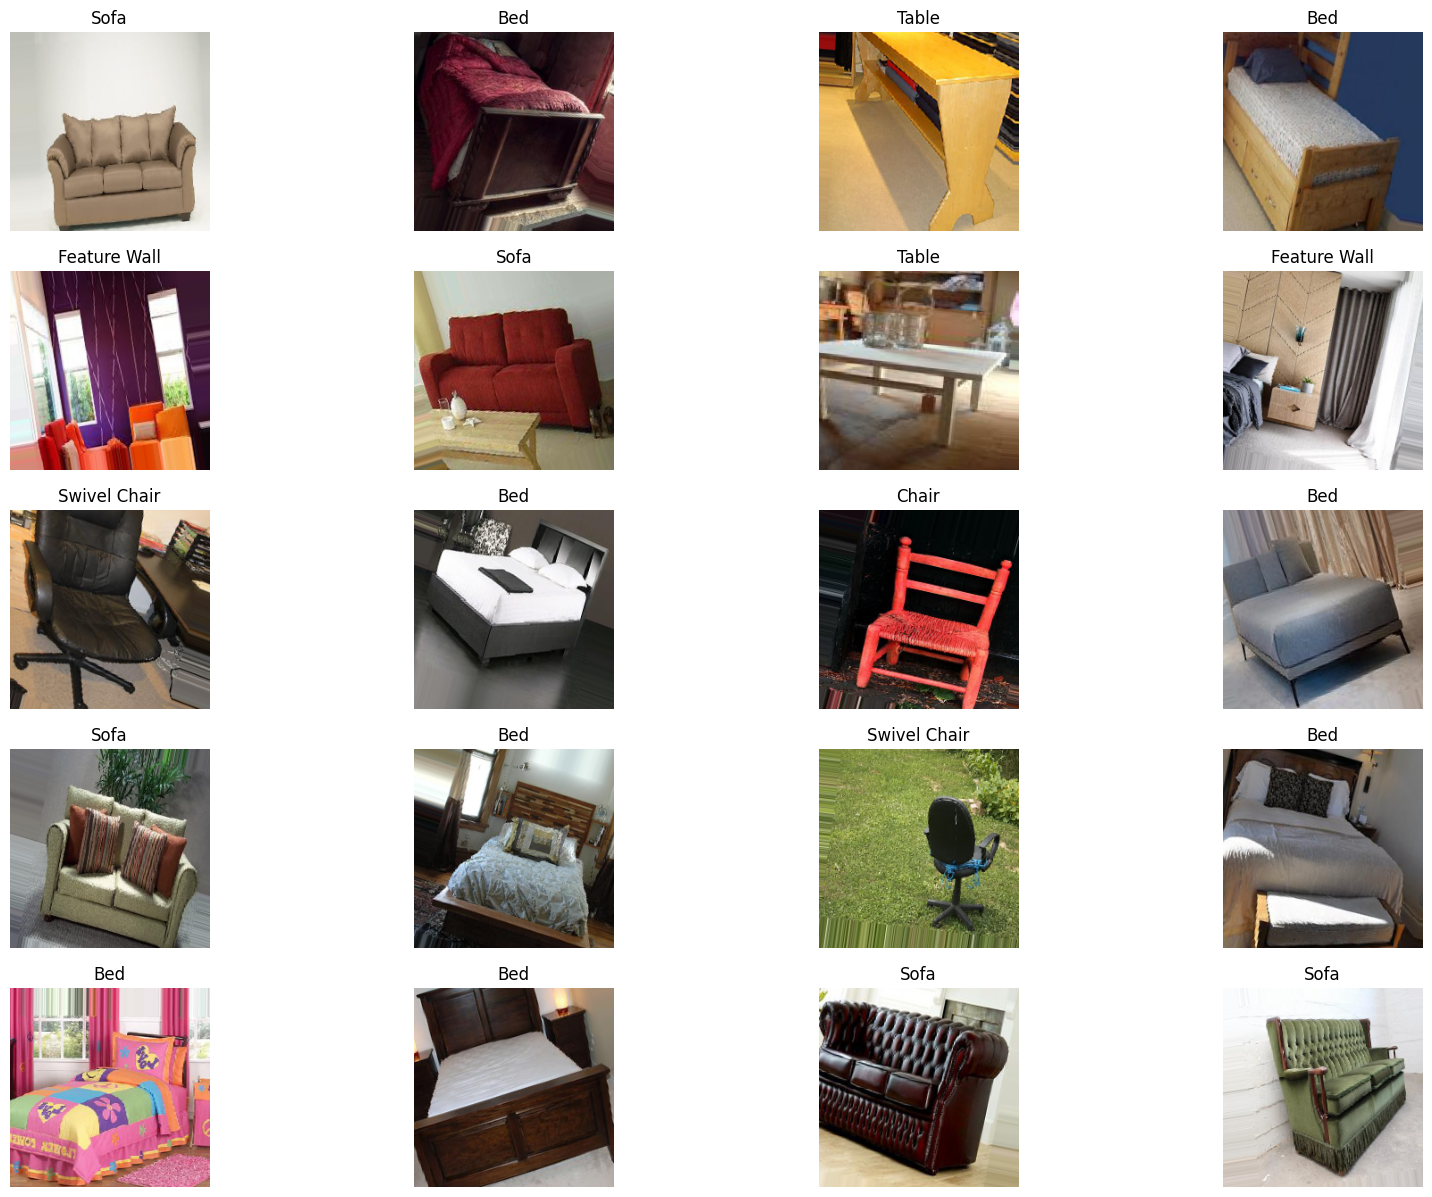

In [ ]:
image_plot(aug_train_generator,20)

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
  weights='imagenet',
  include_top=False,
  input_shape=input_shape
)
base_model.trainable = False
model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())
model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(6, activation='softmax'))
model_vgg16.compile(loss='SparseCategoricalCrossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['acc'])
model_vgg16.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5',monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss",mode="min",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]
history = model_vgg16.fit(aug_train_generator,validation_data = test_generator,epochs=50,shuffle=False,verbose=True,callbacks=callbacks_list)
#steps_per_epoch=10,

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 1.3805 - acc: 0.4542 
Epoch 1: acc improved from -inf to 0.45421, saving model to model/vgg16_best.h5
68/68 [==============================] - 4185s 62s/step - loss: 1.3805 - acc: 0.4542 - val_loss: 0.8582 - val_acc: 0.7027
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 0.8120 - acc: 0.6959
Epoch 2: acc improved from 0.45421 to 0.69588, saving model to model/vgg16_best.h5
68/68 [==============================] - 82s 1s/step - loss: 0.8120 - acc: 0.6959 - val_loss: 0.5596 - val_acc: 0.7796
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 0.6250 - acc: 0.7789
Epoch 3: acc improved from 0.69588 to 0.77891, saving model to model/vgg16_best.h5
68/68 [==============================] - 80s 1s/step - loss: 0.6250 - acc: 0.7789 - val_loss: 0.4455 - val_acc: 0.8295
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 0.5173 - acc: 0.8134
Epoch 4: acc improved from 0.77891 to

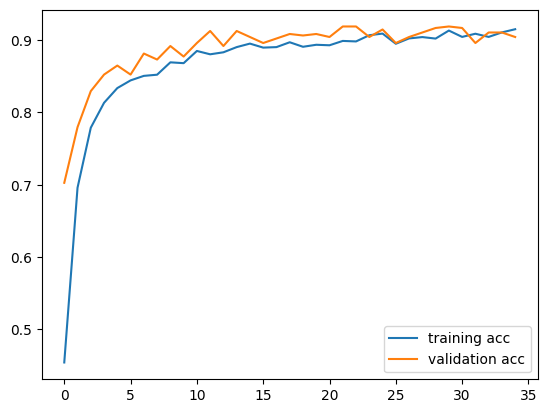

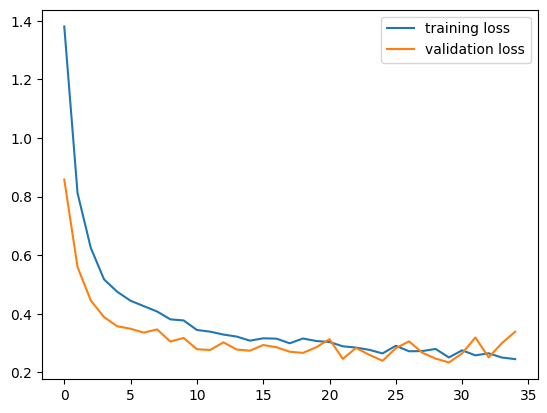

In [ ]:
def plot_learning_curve(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, label='training acc')
  plt.plot(epochs, val_acc, label='validation acc')
  plt.legend();
  plt.figure();
  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='validation loss')
  plt.legend();
plot_learning_curve(history)

In [ ]:
train_result = model_vgg16.evaluate(aug_train_generator)
test_result = model_vgg16.evaluate(test_generator)
augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

8/8 [==============================] - 3s 395ms/step - loss: 0.2338 - acc: 0.9189


Train       Val
Loss  0.176764  0.233767
Acc   0.940333  0.918919

16/16 [==============================] - 7s 150ms/step
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89       100
         1.0       0.95      0.91      0.93       100
         2.0       0.97      0.85      0.90       100
         3.0       0.95      0.95      0.95       100
         4.0       0.92      0.98      0.95        45
         5.0       0.89      0.92      0.90        36

    accuracy                           0.92       481
   macro avg       0.92      0.92      0.92       481
weighted avg       0.92      0.92      0.92       481



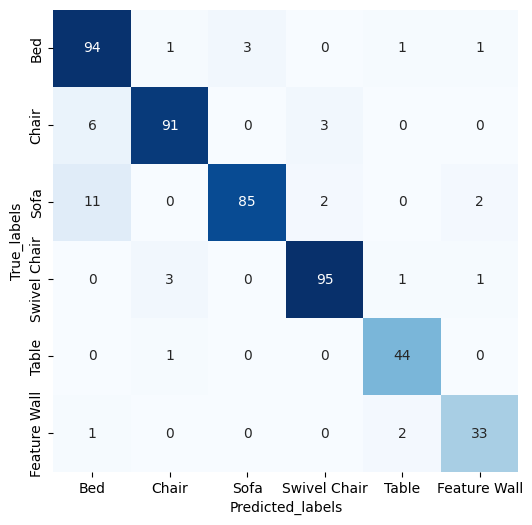

In [ ]:
ytest = np.array([])
xtest = []
for i in range(math.ceil(len(test_generator.classes)/batch_size)):
  xtest.append(test_generator[i][0])
  ytest= np.concatenate((ytest,test_generator[i][-1]))
xtest = np.concatenate((xtest),axis=0)
ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g',cmap='Blues', cbar=False,xticklabels=['Bed','Chair','Sofa','Swivel Chair','Table','Feature Wall'],yticklabels=['Bed','Chair','Sofa','Swivel Chair','Table','Feature Wall'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

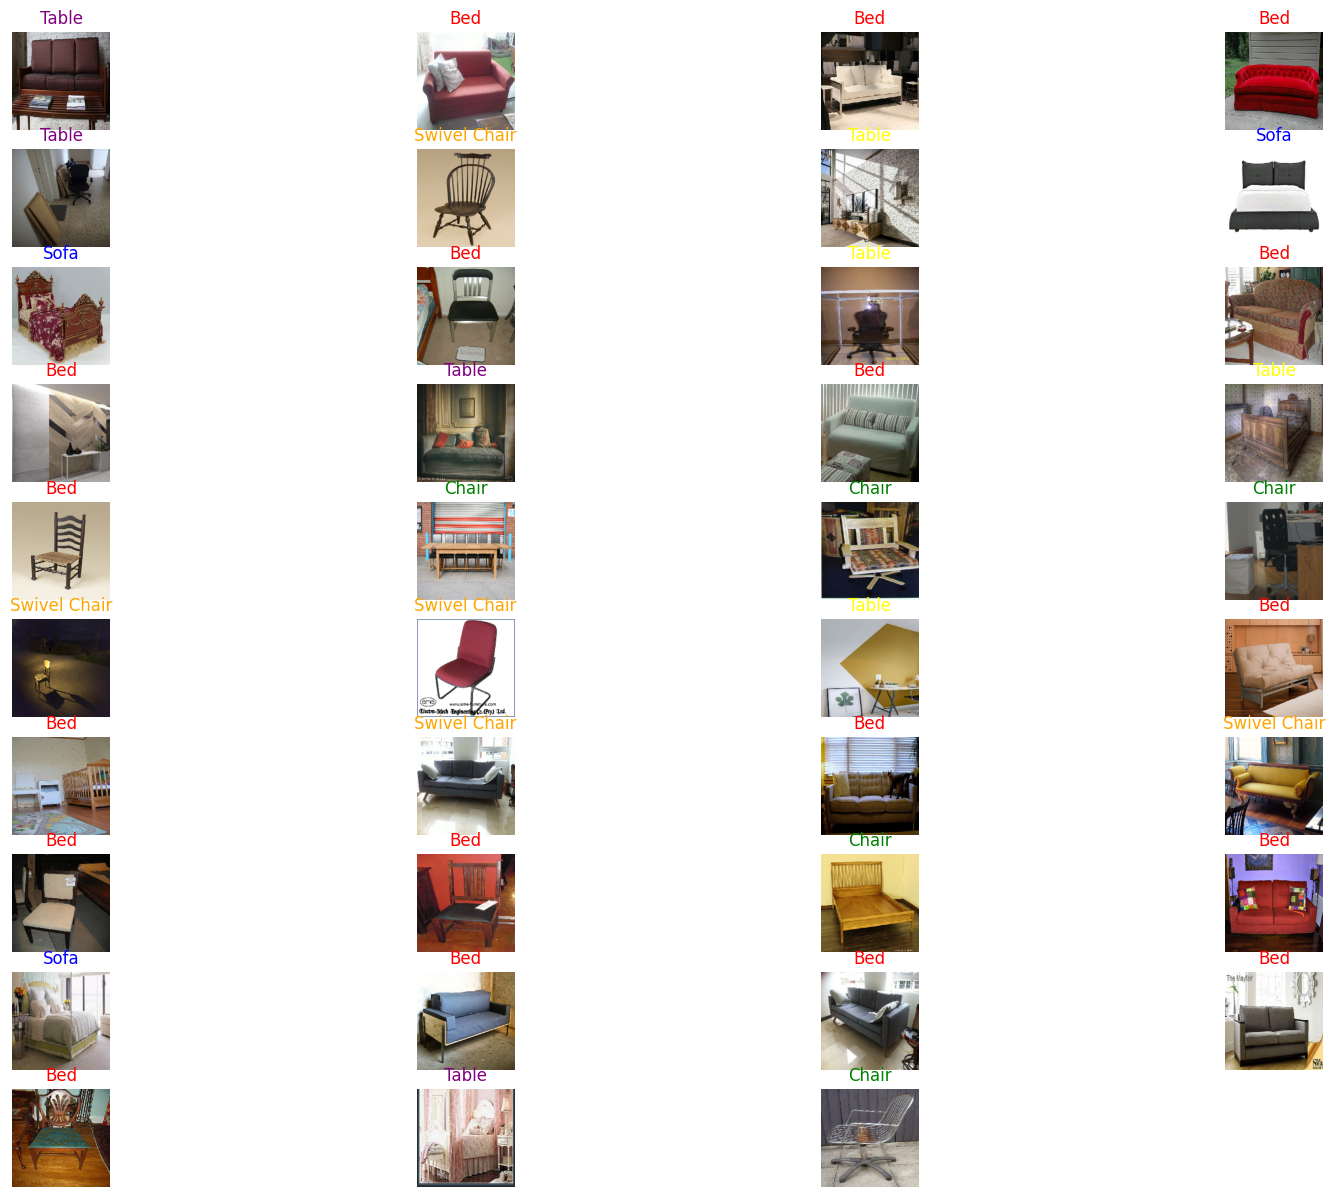

In [ ]:
wrong_pred = np.where(ypred!=ytest)[0]
plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
  ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
  plt.imshow(xtest[n])
  if(ypred[n] == 0):
      plt.title("Bed",color='red')
  elif(ypred[n] == 1):
      plt.title("Chair",color='green')
  elif(ypred[n] == 2):
      plt.title("Sofa",color='blue')
  elif(ypred[n] == 3):
      plt.title("Swivel Chair",color='orange')
  elif(ypred[n] == 4):
      plt.title("Table",color='yellow')
  elif(ypred[n] == 5):
      plt.title("Table",color='purple')
  plt.axis("off")

In [ ]:
# model_vgg16.save('/content/drive/MyDrive/Saved_Model/Furniture Identification/vgg16_model.h5')